# llama3 implemented from scratch
download the weights before running this file: https://llama.meta.com/llama-downloads/

* BPE tokenizer impl example: https://github.com/karpathy/minbpe
* RoPE math: https://www.youtube.com/watch?v=o29P0Kpobz0&t=530s

In [1]:
from pathlib import Path
import json
import matplotlib.pyplot as plt

import torch

# Tokenizer
import tiktoken
from tiktoken.load import load_tiktoken_bpe

In [9]:
model_name = "Meta-Llama-3-8B-Instruct"
tokenizer_path = f"{model_name}/tokenizer.model"

model_path = f"{model_name}/consolidated.00.pth"
tok_embeddings_weight = "tok_embeddings.weight"

config_path = f"{model_name}/params.json"


special_tokens = [
    "<|begin_of_text|>",
    "<|end_of_text|>",
    "<|reserved_special_token_0|>",
    "<|reserved_special_token_1|>",
    "<|reserved_special_token_2|>",
    "<|reserved_special_token_3|>",
    "<|start_header_id|>",
    "<|end_header_id|>",
    "<|reserved_special_token_4|>",
    "<|eot_id|>",  # end of turn
] + [f"<|reserved_special_token_{i}|>" for i in range(5, 256 - 5)]

# Model Representation:
# [
#     "tok_embeddings.weight",
#     "layers.0.attention.wq.weight",
#     "layers.0.attention.wk.weight",
#     "layers.0.attention.wv.weight",
#     "layers.0.attention.wo.weight",
#     "layers.0.feed_forward.w1.weight",
#     "layers.0.feed_forward.w3.weight",
#     "layers.0.feed_forward.w2.weight",
#     "layers.0.attention_norm.weight",
#     "layers.0.ffn_norm.weight",
#     "layers.1.attention.wq.weight",
#     "layers.1.attention.wk.weight",
#     "layers.1.attention.wv.weight",
#     "layers.1.attention.wo.weight",
#     "layers.1.feed_forward.w1.weight",
#     "layers.1.feed_forward.w3.weight",
#     "layers.1.feed_forward.w2.weight",
#     "layers.1.attention_norm.weight",
#     "layers.1.ffn_norm.weight",
#     "layers.2.attention.wq.weight"
# ]

In [7]:
# Utils
def load_json(filename):
    with open(filename, "r") as f:
        return json.load(f)

## Load model and configs

In [8]:
# Example view: print(json.dumps(list(model.keys())[:20], indent=4))
model = torch.load(model_path)                          # consolidated.00.pth

In [10]:
# Example usage: tokenizer.decode(tokenizer.encode("hello world!"))
_mergeable_ranks = load_tiktoken_bpe(tokenizer_path)     # tokenizer.model
tokenizer = tiktoken.Encoding(
    name=Path(tokenizer_path).name,
    pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+",
    mergeable_ranks=_mergeable_ranks,
    special_tokens={token: len(_mergeable_ranks) + i for i, token in enumerate(special_tokens)},
)

_config = load_json(config_path)
dim = _config["dim"]                    # 4096 embedding dimensions
n_layers = _config["n_layers"]          # 32 transformer layers
n_heads = _config["n_heads"]            # each multi-head attn block has 32 heads
n_kv_heads = _config["n_kv_heads"]      # 8
vocab_size = _config["vocab_size"]      # 128256
multiple_of = _config["multiple_of"]    # 1024
ffn_dim_multiplier = _config["ffn_dim_multiplier"]  # 1.3
norm_eps = _config["norm_eps"]          # 1e-05
rope_theta = torch.tensor(_config["rope_theta"])  # 500_000 controls frequency of positional embeddings

embedding_layer = torch.nn.Embedding(vocab_size, dim)
embedding_layer.weight.data.copy_(model[tok_embeddings_weight])

def rms_norm(tensor, norm_weights):
    return (
        tensor * torch.rsqrt(
            tensor.pow(2).mean(-1, keepdim=True) + norm_eps
        )
    ) * norm_weights

## Inference

In [20]:
# Example view: prompt_split_astokens = [tokenizer.decode([token.item()]) for token in tokens]
_prompt = "the answer to the ultimate question of life, the universe, and everything is "
tokens = torch.tensor([128000] + tokenizer.encode(_prompt))  # add <|begin_of_text|> token -> 17
final_embedding = token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)    # 17 x 4096 (dim)

# For RoPE rotation matrix
_zero_to_one_split_into_64_parts = torch.tensor(range(64))/64   # 64 = dim / n_heads / 2: num pairs in 1 head
freqs = 1.0 / (rope_theta ** _zero_to_one_split_into_64_parts)
_freqs_for_each_token = torch.outer(torch.arange(tokens.shape[0]), freqs)                  # [17, 64]: positional index x freqs
freqs_cis = torch.polar(torch.ones_like(_freqs_for_each_token), _freqs_for_each_token)     # [17, 64]: complex numbers representing frequency for a specific token-position pair

# Mask: upper triangular matrix filled with -inf, elements below are set to 0
mask = torch.full((len(token_embeddings_unnormalized), len(token_embeddings_unnormalized)), float("-inf"))
mask = torch.triu(mask, diagonal=1)     

for layer in range(n_layers):
    qkv_attention_store = []
    # 1. Embedding Delta from Multi-Head Self-Attention
    #   RMS Normalization
    layer_embedding_norm = rms_norm(
        final_embedding, 
        model[f"layers.{layer}.attention_norm.weight"]
    )
    #   Attention: W_Q [dim x dim], W_K [dim/4 x dim], W_V [dim/4 x dim], W_O [dim x dim]
    #       Weights for keys and values are shared across 4 heads at a time (to reduce the number of computations)
    q_layer = model[f"layers.{layer}.attention.wq.weight"]
    q_layer = q_layer.view(n_heads, q_layer.shape[0] // n_heads, dim)           # [32, 128, 4096]
    k_layer = model[f"layers.{layer}.attention.wk.weight"]
    k_layer = k_layer.view(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)     # [8, 128, 4096]
    v_layer = model[f"layers.{layer}.attention.wv.weight"]
    v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)     # [8, 128, 4096]
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    #   Multi-Head Attention
    for head in range(n_heads):
        q_layer_head = q_layer[head]        # W_Q for 1 head: [128, 4096]
        k_layer_head = k_layer[head//4]     # W_K for 1 head: [128, 4096]
        v_layer_head = v_layer[head//4]     # W_V for 1 head: [128, 4096]
        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T)    # Q of input X for 1 head: [17, 128]    (17 tokens, each with a 128 length query)
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)    # K                        [17, 128]
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)    # V                        [17, 128]
        # RoPE: use dot product of complex numbers to rotate a vector
        q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)                    # [17, 64, 2]
        q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)                    # [17, 64]
        q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis)   # [17, 64, 2]
        q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)                      # [17, 128]
        # RoPE
        k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)                    # [17, 64, 2]
        k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)                    # [17, 64]
        k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)   # [17, 64, 2]
        k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)                      # [17, 128]
        # Attention Score Matrix (Self-Attention)
        qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5                      # [17, 17]
        #     Mask scores
        qk_per_token_after_masking = qk_per_token + mask                    # masked positions (upper triangle) set to -inf
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)    # softmax along cols
        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)                     # [17, 128]
        qkv_attention_store.append(qkv_attention)
    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)      # [17, 4096]
    #   Linear output layer
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)    # [17, 4096]
    #   Update Embedding
    embedding_after_edit = final_embedding + embedding_delta
    # 2. Embedding Delta from FFN
    #   RMS Normalization
    embedding_after_edit_normalized = rms_norm(
        embedding_after_edit, 
        model[f"layers.{layer}.ffn_norm.weight"]
    )
    #   SwiGLU FFN
    w1 = model[f"layers.{layer}.feed_forward.w1.weight"]
    w2 = model[f"layers.{layer}.feed_forward.w2.weight"]
    w3 = model[f"layers.{layer}.feed_forward.w3.weight"]
    output_after_feedforward = torch.matmul(
        torch.functional.F.silu(
            torch.matmul(
                embedding_after_edit_normalized, 
                w1.T,
            )
        ) * torch.matmul(
            embedding_after_edit_normalized, 
            w3.T,
        ), 
        w2.T)
    #   Update Embedding
    final_embedding = embedding_after_edit + output_after_feedforward

# Predict
logits = torch.matmul(final_embedding[-1], model["output.weight"].T)   # 128,256
next_token = torch.argmax(logits, dim=-1)
tokenizer.decode([next_token.item()])

'42'

<div>
    <img src="images/norm.png" width="600"/>
</div>

<div>
    <img src="images/qkv.png" width="600"/>
</div>

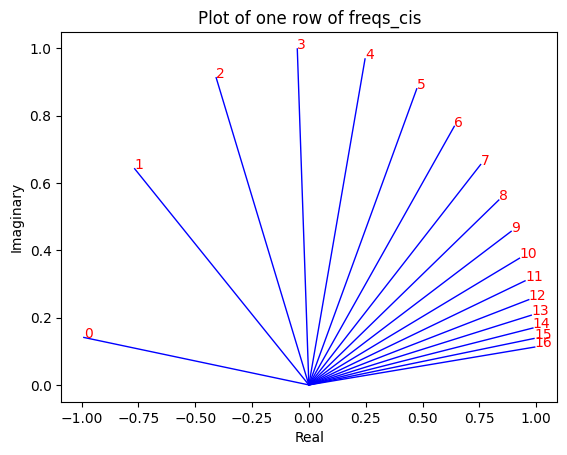

In [12]:
# viewing tjhe third row of freqs_cis
value = freqs_cis[3]
plt.figure()
for i, element in enumerate(value[:17]):
    plt.plot([0, element.real], [0, element.imag], color='blue', linewidth=1, label=f"Index: {i}")
    plt.annotate(f"{i}", xy=(element.real, element.imag), color='red')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Plot of one row of freqs_cis')
plt.show()

<div>
    <img src="images/mask.png" width="600px"/>
</div>

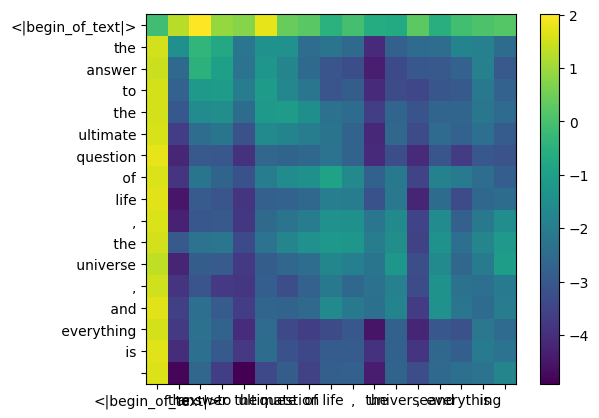

In [18]:
def display_qk_heatmap(qk_per_token, prompt_split_astokens):
    _, ax = plt.subplots()
    im = ax.imshow(qk_per_token.to(float).detach(), cmap='viridis')
    ax.set_xticks(range(len(prompt_split_astokens)))
    ax.set_yticks(range(len(prompt_split_astokens)))
    ax.set_xticklabels(prompt_split_astokens)
    ax.set_yticklabels(prompt_split_astokens)
    ax.figure.colorbar(im, ax=ax)
    
display_qk_heatmap(qk_per_token, prompt_split_astokens=[tokenizer.decode([token.item()]) for token in tokens])

In [14]:
mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
mask = torch.triu(mask, diagonal=1)
mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -in

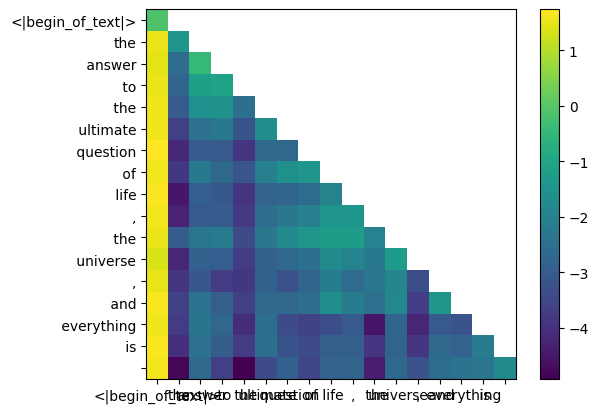

In [15]:
qk_per_token_after_masking = qk_per_token + mask
display_qk_heatmap(qk_per_token_after_masking, prompt_split_astokens=[tokenizer.decode([token.item()]) for token in tokens])

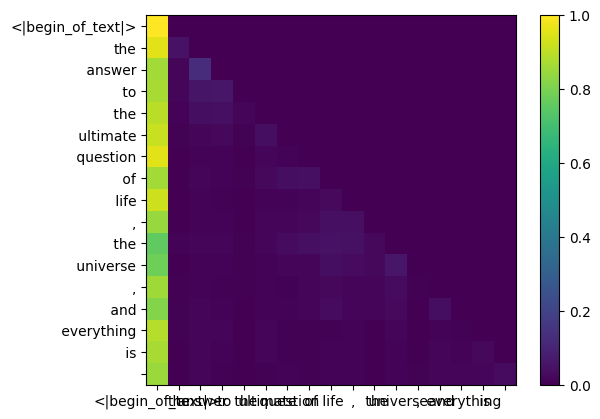

In [17]:
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
display_qk_heatmap(qk_per_token_after_masking_after_softmax, prompt_split_astokens=[tokenizer.decode([token.item()]) for token in tokens])

<div>
    <img src="images/attention.png" width="600px"/>
</div>

## we normalize and then run a feed forward neural network through the embedding delta
<div>
    <img src="images/norm_after.png" width="600px"/>
</div>

<div>
    <img src="images/swiglu.png" width="600px"/>
</div>

<div>
    <img src="images/last_norm.png" width="600px"/>
</div>

<div>
    <img src="images/finallayer.png" width="600px"/>
</div>